# Socioeconomic Impacts of the Palisades and Eaton Fires in Los Angeles County

Author: Nathalie Bonnet

Github: https://github.com/NatBonnet/eds220-la-fires-eji

## About
This notebook contains the data wrangling and processing to clip to the areas defined by wildfire perimeter data and visualize the social dimensions of the residents impacted to support discussion for a final blog post. 

## Highlights
- Analysis provides an overview of good practices when exploring and subsetting `geopandas.GeoDataFrames` 
- A spatial join is used to combine EJI data with fire perimeter boundaries
- We explore the use of a custom color bar to fit data values to two different dataset and maps

## Data sources

### Fires data
Overview:
This dataset was retrieved from the California State Geoportal Historical Wildland Fire Perimeters database. The data include geographic data as well as fire id and date information. 

Fire Perimeter Data: California State Geoportal. California Historical Fire Perimeters [Dataset]. https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-historical-fire-perimeters/explore?layer=2&location=37.338129%2C-119.269051%2C6.09&showTable=true

### EJI data
This dataset can be retrieved fro, the CDC's website as a geodatabase. EJI data aims to address environmental injustice issues in the U.S. population.

Centers for Disease Control and Prevention and Agency for Toxic Substances Disease Registry. 2024 Environmental Justice Index [Dataset]. https://atsdr.cdc.gov/place-health/php/eji/eji-data-download.html


### Setup

In [18]:
import os
import geopandas as gpd
import rioxarray as rioxr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import contextily as ctx

In [19]:
# Import data
fp = os.path.join('data', 'California_Historic_Fire_Perimeters_-247493000743518952', 'California_Fire_Perimeters_(1950+).shp')
fires = gpd.read_file(fp)

fp= os.path.join('data', 'EJI_2024_United_States', 'EJI_2024_United_States.gdb')
eji = gpd.read_file(fp)


In any geospatial analysis with multiple data sets it is beneficial to view the CRS and column names of each to compare if they are able to be processed together.

In [20]:
# Check crs of each data
print(fires.crs)
print(fires.crs.is_projected)

print(eji.crs)
print(eji.crs.is_projected)

EPSG:3857
True
PROJCS["USA_Contiguous_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",37.5],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102003"]]
True


In [21]:
# Print the head of the data frame to get an overview
fires.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2025,CA,CDF,LDF,PALISADES,00000738,2025-01-07,2025-01-31,14,7,1,23448.900,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-13193558.265 4032826.468, -13..."
1,2025,CA,CDF,LAC,EATON,00009087,2025-01-08,2025-01-31,14,7,1,14056.300,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-13146936.686 4051222.067, -13..."
2,2025,CA,CDF,ANF,HUGHES,00250270,2025-01-22,2025-01-28,14,7,1,10396.800,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-13197885.239 4107084.744, -13..."
3,2025,CA,CCO,VNC,KENNETH,00003155,2025-01-09,2025-02-04,14,2,1,998.738,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-13211054.577 4051508.758, -13211051..."
4,2025,CA,CDF,LDF,HURST,00003294,2025-01-07,2025-01-09,14,7,1,831.385,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-13187991.688 4073306.403, -13187979..."


In [22]:
# View unique column names in df
fires.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NA', 'IRWINID', 'FIRE_NUM',
       'COMPLEX_ID', 'DECADES', 'geometry'],
      dtype='object')

In [23]:
# Update the column names to be lower case for easier standard processing
fires.columns = fires.columns.str.lower()


In this analysis, we were interested in investigating the social dynamics within the geographic areas affected by the 2025 Palisades and Eaton fires.

In [24]:
# Explore the unique names of the fire
fires.fire_name.unique()

array(['PALISADES', 'EATON', 'HUGHES', ..., 'PEREZ', 'GOAT MTN',
       'MCCOULTER'], dtype=object)

From this output we know we need to filter for only Palisades fire and Eaton fire data from 2025

In [25]:
# Filter to create new fire gdb for each fire
palisade = fires[(fires['fire_name'] == 'PALISADES') & (fires['year_'] == 2025)]
eaton = fires[(fires['fire_name'] == 'EATON') & (fires['year_'] == 2025)]

Now to finish setting up for a spatial join, we set the CRS of `eji` equal to that of `fires`.

In [26]:
# Set CRS
eji = eji.to_crs(crs = 'epsg:3857')

### Spatially join data
Now that we have filtered to target fires and fixed the CRS and names, we are able to join `eji` on the geography of fire data with an inner join.

In [27]:
# Spatial join eji and palisades 
palisade_soc = gpd.sjoin(left_df = eji, 
                        right_df = palisade,
how = 'inner')

### Visualize output of spatial join for palisades data

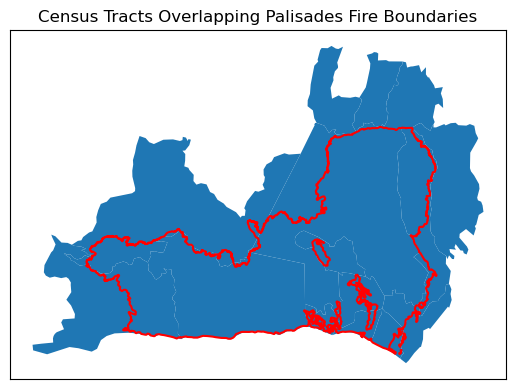

In [28]:
# Plot the boundary of palisades fire versus the polygons for the joined data
fig, ax = plt.subplots()
palisade_soc.plot(ax=ax)
palisade.boundary.plot(ax=ax, edgecolor = "red")
plt.title("Census Tracts Overlapping Palisades Fire Boundaries")
# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])   

plt.show()

The output plot here shows that the true perimeter of the fire is contained, but `eji` importantly joined census tracts by geometry, so we see the entire census tract geometry returned rather than it being clipped to the exact extent of the Palisades fire. We can confirm this with Eaton fire data.

In [29]:
# Create geodf for the Eaton fire
# Spatial join
eaton_soc = gpd.sjoin(eji, eaton,
how = 'inner')

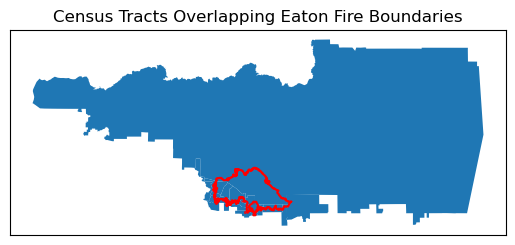

In [30]:
# Plot eji data with Eaton fire perimeter
fig, ax = plt.subplots()
eaton_soc.plot(ax=ax)
eaton.boundary.plot(ax=ax, edgecolor = "red")
plt.title("Census Tracts Overlapping Eaton Fire Boundaries")
# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

plt.show()

We observe the same thing here with the Eaton fire.

### Clipping spatial extent

To get an exact fit of EJI data within the fire perimeters, we can clip the dat with the exact boundaries of fires.

In [31]:
# Clip the census tracts overlapping palisades to the boundary of the fire
palisade_clip = gpd.clip(eji, palisade)

Plotting the clipped version, we now see that census tracts are contained exactly by the perimeter.

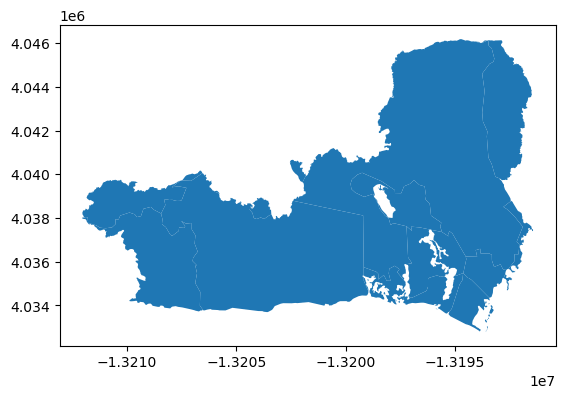

In [32]:
# Plot clipped eji and palisades fire overlap
fig, ax = plt.subplots()
palisade_clip.plot(ax=ax)
plt.show()

And we can confirm with Eaton fire perimeter.

In [33]:
# Clip the overlap of census tracts with the eaton fire
eaton_clip = gpd.clip(eji, eaton)

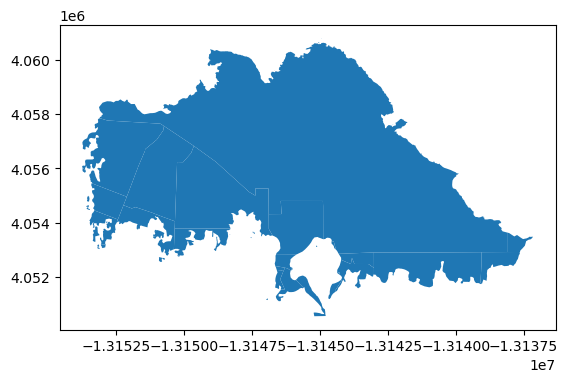

In [34]:
# Plot clipped Eaton data
fig, ax = plt.subplots()
eaton_clip.plot(ax=ax)
plt.show()

### Visualize extent of Eaton and Palisades fire in LA
To compare the spatial areas affected by the fires, we can plot them in the same axis because they share a crs. We are also able to use `contextily` to access basemaps. Here we used OpenStreetMap.


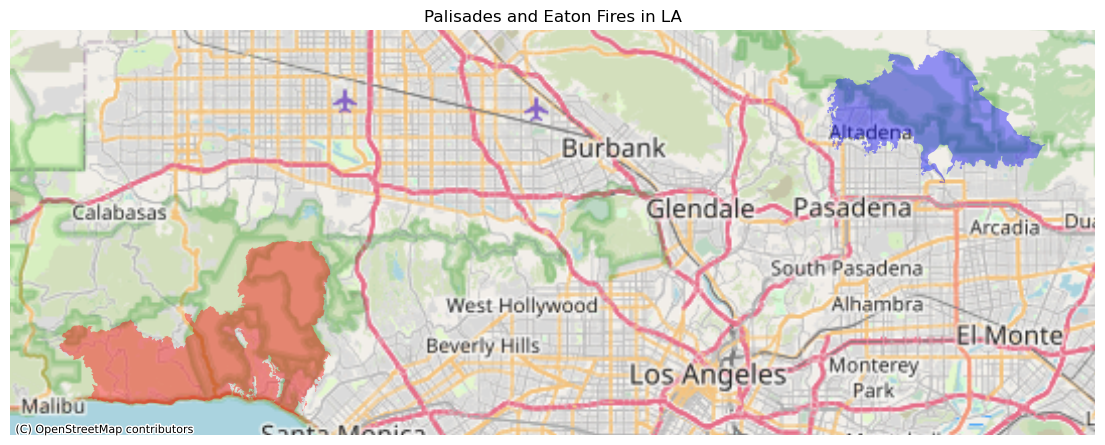

In [35]:
# Plot areas of fires together with a basemap
fig, ax = plt.subplots(1, 1, figsize=(14, 12))

# Palisade area
palisade.plot(ax=ax, color = "red", alpha = 0.4)

# Eaton plot
eaton.plot(ax=ax, color = "blue", alpha = 0.4)

# Add basemap using contextily
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, crs = palisade.crs)

# Create overall title
ax.set_title("Palisades and Eaton Fires in LA")

# Turn axes off for nicer visual output
ax.axis('off')


plt.show()

## Visualize census information in fire areas
Now, we want to select a variable measured by EJI to compare between fire areas. Particularly, we might want to visualize a variable that would potentially result in environmental injustices in the recovery from fires. I was interested in looking at poverty as a clear predictor of housing burden in these residences. From the EJI metadata, poverty is represented with 'E_POV200'- which is stored to pull out colummn values in the joined data.

 One factor we had to account for was that the range of values measured by EJI for a given variable with vary by area, so we had to create a scale to apply to the mapped data so that color values mapped would measured the same values in each plot. This was achieved by setting an overall minimum and maximum value, and using that to create a custom color bar for both maps.

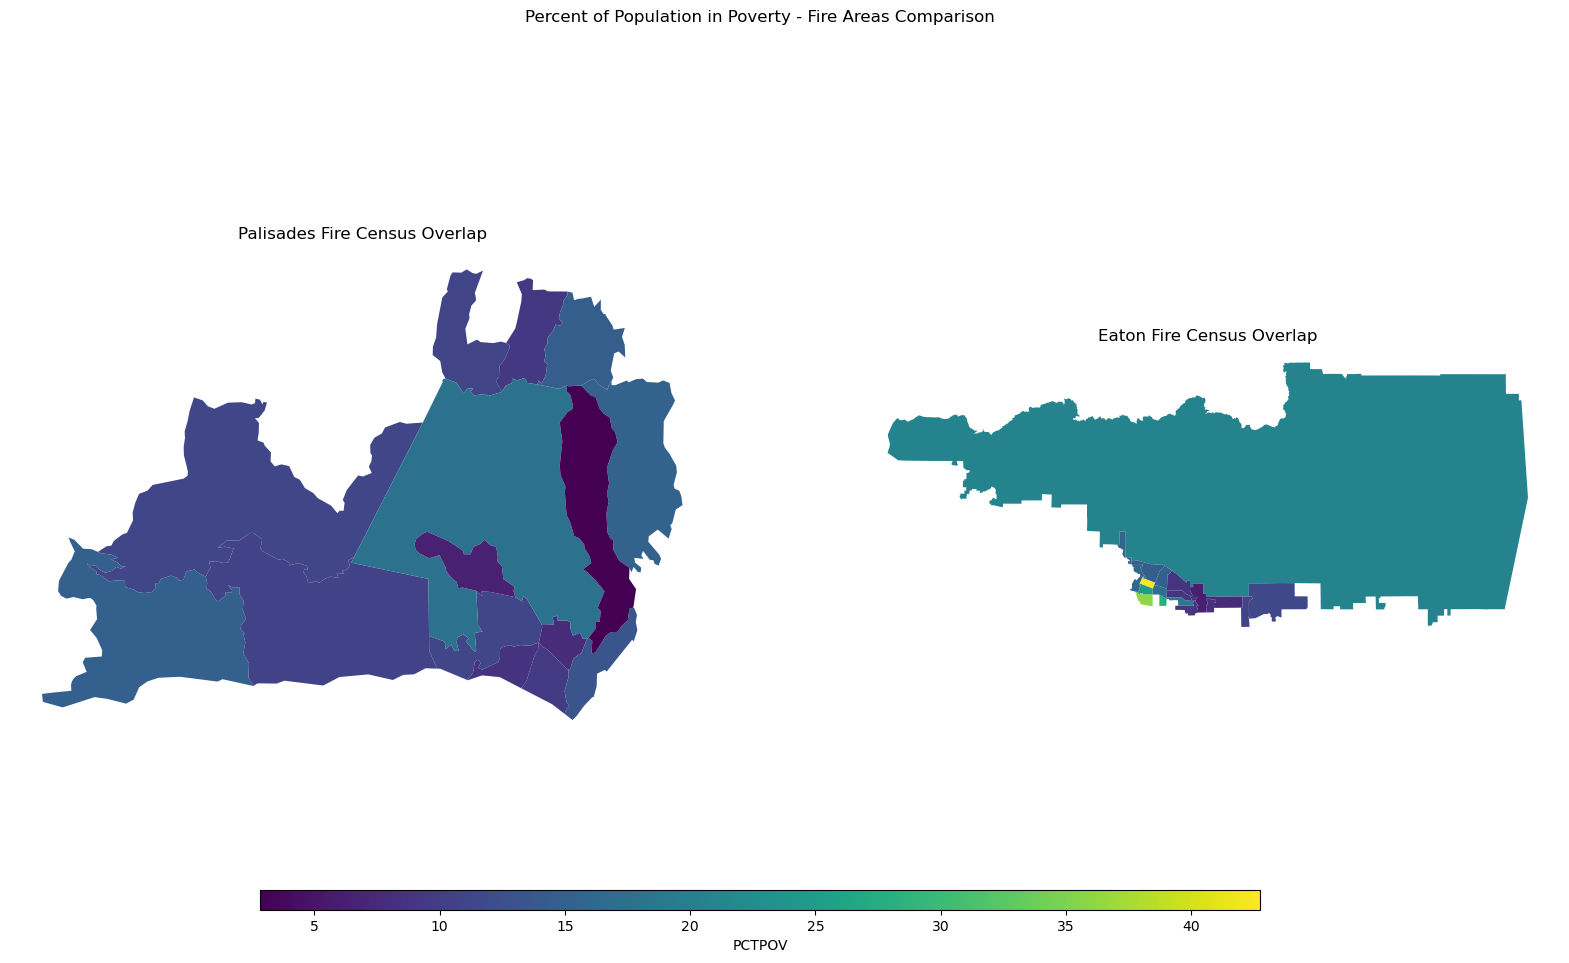

In [36]:
# Initialize plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# store variable of interest
eji_variable = 'E_POV200'

# Find common min/max for legend range
vmin = min(palisade_soc[eji_variable].min(), eaton_soc[eji_variable].min())
vmax = max(palisade_soc[eji_variable].max(), eaton_soc[eji_variable].max())

# Plot census tracts within Palisades perimeter with scaled values
palisade_soc.plot(
    column= eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax1,
)
# Title for Palisades subplot
ax1.set_title('Palisades Fire Census Overlap')

# Remove axes
ax1.axis('off')

# Plot census tracts within Eaton perimeter with scaled values
eaton_soc.plot(
    column=eji_variable,
    vmin=vmin, vmax=vmax,
    legend=False,
    ax=ax2,
)

# Create title for Eaton subplot
ax2.set_title('Eaton Fire Census Overlap')

# Remove axes
ax2.axis('off')

# Add overall title
fig.suptitle('Percent of Population in Poverty - Fire Areas Comparison')

# Add shared colorbar at the bottom
sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=vmin, vmax=vmax))
cbar_ax = fig.add_axes([0.25, 0.08, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
cbar.set_label('PCTPOV')

plt.show()